In [49]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from collections import Counter
import pydicom
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [117]:
df = pd.read_csv('/kaggle/input/train-test-clean/train_df_cleaned.csv')

In [118]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [119]:
print(df.shape)

(32701, 8)


In [120]:
df.isna().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

# Drop 2 columns 'benign_malignant', 'target'

In [121]:
df.drop(['benign_malignant', 'target'], inplace=True, axis = 1)

# Replace diagnosis column values
    + UNK: Unknown, bệnh lý không rõ ràng
    + NV: Nevus, nốt ruồi
    + MEL: Melanoma, một dạng ung thư da ác tính xuất phát từ các tế bào sắc tố (melanocytes)
    + BKL: Benign Keratosis-like Lesions, một số loại tổn thương da lành tính có đặc điểm tương tự như keratosis. BKL bao gồm "seborrheic keratosis", "lentigo NOS", "lichenoid keratosis", và "solar lentigo". Các loại tổn thương này thường không gây nguy hiểm nhưng có thể gây nhầm lẫn với các loại tổn thương ác tính khác nếu không được kiểm tra kỹ lưỡng.

In [122]:
df = df.replace({
    'diagnosis': {
        'unknown': 'UNK',
        'nevus': 'NV',
        'melanoma': 'MEL',
        'seborrheic keratosis': 'BKL',
        'lentigo NOS': 'BKL',
        'lichenoid keratosis': 'BKL',
        'solar lentigo': 'BKL',
        'cafe-au-lait macule': 'UNK',
        'atypical melanocytic proliferation': 'UNK'
    }
})

In [123]:
print(df['diagnosis'].value_counts())

diagnosis
UNK    26708
NV      5191
MEL      581
BKL      221
Name: count, dtype: int64


In [124]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,UNK
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,UNK
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,NV
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,UNK
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,UNK


# Idea: Mô hình sẽ được đưa về phân loại các loại diagnosis

# LOAD IAMGES JPEG

In [12]:
def load_images(PATH):
    images = []
    for filename in os.listdir(PATH):
        if filename.endswith(".jpg"):  
            img_path = os.path.join(PATH, filename)
            try:
                img = Image.open(img_path)  
                images.append(img) 
            except IOError:
                print(f"Cannot load image '{filename}'")
    return images


In [17]:
PATH = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
images = load_images(PATH)

In [ ]:
# len(images)

In [22]:
def filter_images(loaded_images, df_train):
    valid_image_names = set(df_train['image_name'].unique())

    filtered_images = []

    for img in loaded_images:
        img_name = os.path.basename(img.filename).split('.')[0]

        if img_name in valid_image_names:
            filtered_images.append(img)

    return filtered_images

In [23]:
images1 = filter_images(images, df_train)

In [ ]:
# len(images1)

In [ ]:
# def save_images_to_folder(filtered_images, destination_folder):
#     if not os.path.exists(destination_folder):
#         os.makedirs(destination_folder)
    
#     for img in filtered_images:
#         img_name = os.path.basename(img.filename)
        
#         save_path = os.path.join(destination_folder, img_name)
        
#         img.save(save_path)

#     print(f"Saved {len(filtered_images)} images to folder '{destination_folder}'.")


In [ ]:
# destination_folder = '/kaggle/working/.jpeg/train/'

# save_images_to_folder(images1, destination_folder)

In [18]:
def visualize_image_size(images):
    dimensions = [(img.size[0], img.size[1]) for img in images]

    dimension_counts = Counter(dimensions)

    sorted_dimensions = sorted(dimension_counts.items(), key=lambda x: x[1], reverse=True)

    labels = [f'{dim[0]}x{dim[1]}' for dim, count in sorted_dimensions]
    counts = [count for dim, count in sorted_dimensions]

    plt.figure(figsize=(10, 8))
    plt.bar(range(len(counts)), counts, tick_label=labels, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Image Size Distribution')
    plt.xlabel('Width x Height')
    plt.ylabel('Number of Photos')
    plt.tight_layout()  
    plt.show()

In [19]:
def count_image_sizes(images):
    sizes = [(img.size[0], img.size[1]) for img in images]

    size_counts = Counter(sizes)

    total_unique_sizes = len(size_counts)
    print(f"There are a total of {total_unique_sizes} of different sizes.")

    top_5_sizes = size_counts.most_common(5)

    print("Top 5 sizes:")
    for size, count in top_5_sizes:
        print(f"Size {size[0]}x{size[1]} with {count} images")

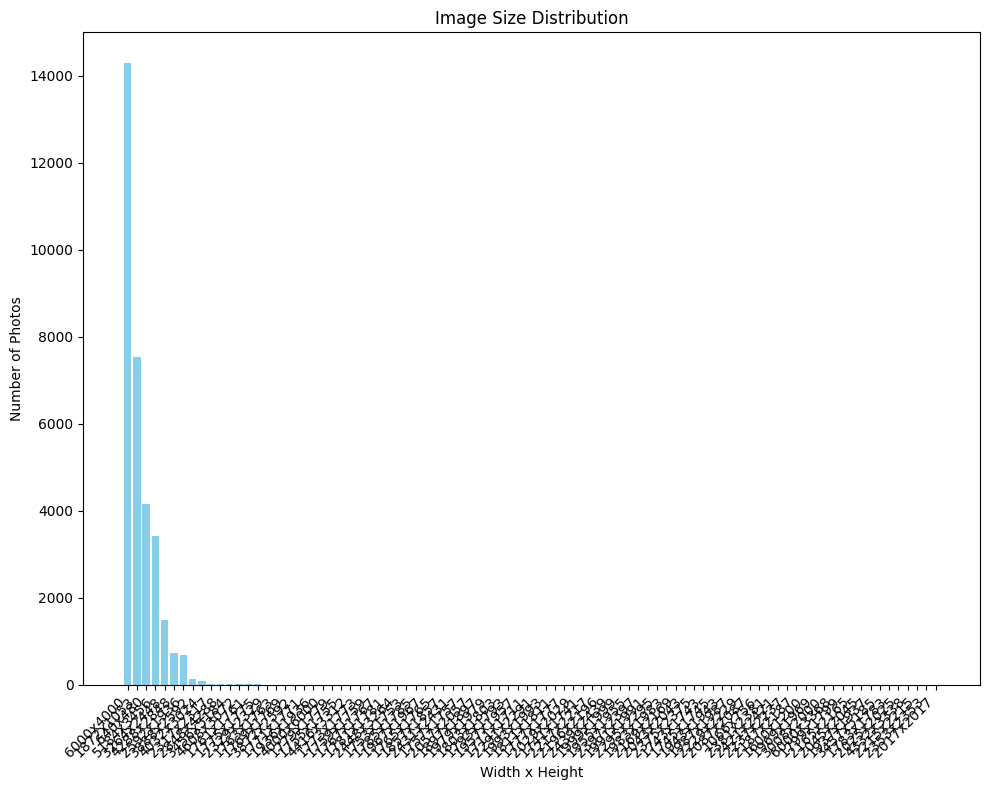

In [24]:
visualize_image_size(images1)

In [25]:
count_image_sizes(images1)

There are a total of 88 of different sizes.
Top 5 sizes:
Size 6000x4000 with 14285 images
Size 1872x1053 with 7534 images
Size 640x480 with 4147 images
Size 5184x3456 with 3412 images
Size 3264x2448 with 1483 images


In [ ]:
# def check_image_channels(images):
#     first_image_channels = len(images[0].getbands())

#     for img in images[1:]:
#         if len(img.getbands()) != first_image_channels:
#             return False

#     return True


In [ ]:
# check_image_channels(images1)

In [ ]:
# def show_images_by_diagnosis(images, df_train, diagnosis_value, num_images=1):
#     filtered_df = df_train[df_train['diagnosis'] == diagnosis_value]['image_name']
    
#     count = 0

#     for img in images:
#         if count >= num_images:
#             break

#         img_name = os.path.basename(img.filename).split('.')[0]

#         if img_name in filtered_df.values:
#             fig, ax = plt.subplots(figsize=(5, 5))
#             if img.mode != 'RGB':
#                 img = img.convert('RGB')
#             ax.imshow(img)
#             ax.set_title(f"{diagnosis_value} - {img_name}")
#             ax.axis('off')

#             count += 1

In [ ]:
# show_images_by_diagnosis(images1, df_train, 'MEL', num_images=5)

In [ ]:
# show_images_by_diagnosis(images1, df_train, 'UNK', num_images=2)

In [ ]:
# show_images_by_diagnosis(images1, df_train, 'NV', num_images=2)

In [ ]:
# show_images_by_diagnosis(images1, df_train, 'BKL', num_images=2)

## Preprocess csv files

In [125]:
directory = '../input/siim-isic-melanoma-classification'
path_train = directory + '/jpeg/train/' + df['image_name'] + '.jpg'

df['path_jpeg'] = path_train

In [126]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,path_jpeg
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,UNK,../input/siim-isic-melanoma-classification/jpe...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,UNK,../input/siim-isic-melanoma-classification/jpe...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,NV,../input/siim-isic-melanoma-classification/jpe...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,UNK,../input/siim-isic-melanoma-classification/jpe...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,UNK,../input/siim-isic-melanoma-classification/jpe...


In [127]:
path_train = directory + '/train/' + df['image_name'] + '.dcm'

df['path_dicom'] = path_train


In [128]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,path_jpeg,path_dicom
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,UNK,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,UNK,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,NV,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,UNK,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,UNK,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...


In [129]:
def encode_labels(df, column_name):
    """
    Encodes the labels in the specified column of the DataFrame using LabelEncoder.
    
    """
    label_encoder = LabelEncoder()
    
    df[column_name] = label_encoder.fit_transform(df[column_name])
    
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    
    return df, label_mapping

In [130]:
cols = ['sex', 'anatom_site_general_challenge', 'diagnosis']
for col in cols:
    df, label_mapping = encode_labels(df, col)
    print(label_mapping)

{'female': 0, 'male': 1}
{'head/neck': 0, 'lower extremity': 1, 'oral/genital': 2, 'palms/soles': 3, 'torso': 4, 'upper extremity': 5}
{'BKL': 0, 'MEL': 1, 'NV': 2, 'UNK': 3}


In [131]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,path_jpeg,path_dicom
0,ISIC_2637011,IP_7279968,1,45.0,0,3,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
1,ISIC_0015719,IP_3075186,0,45.0,5,3,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
2,ISIC_0052212,IP_2842074,0,50.0,1,2,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
3,ISIC_0068279,IP_6890425,0,45.0,0,3,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...
4,ISIC_0074268,IP_8723313,0,55.0,5,3,../input/siim-isic-melanoma-classification/jpe...,../input/siim-isic-melanoma-classification/tra...


In [92]:
# X = df.drop('diagnosis', axis=1)
# y = df['diagnosis']

In [133]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.25, random_state=42)

In [134]:
train_data.shape, val_data.shape, test_data.shape

((26160, 8), (4905, 8), (1636, 8))

In [135]:
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# EDA

# 1. train_data

In [99]:
def convert_numerical_to_object(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str)  # Convert to string, which is an object type
        print(f"Column '{column_name}' converted to object type.")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
    return df

In [137]:
cols = ['sex', 'anatom_site_general_challenge','diagnosis']
for col in cols:
    convert_numerical_to_object(train_data, col)

Column 'sex' converted to object type.
Column 'anatom_site_general_challenge' converted to object type.
Column 'diagnosis' converted to object type.


In [152]:
def plot_data_distribution(df, column_name):
    if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
        # It's categorical, use countplot
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index)
        plt.title(f'Distribution of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
    else:
        # It's numerical, use histplot
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=column_name, kde=True, bins=30)
        plt.title(f'Distribution of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.show()


/tmp/ipykernel_33/3582844581.py:2: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


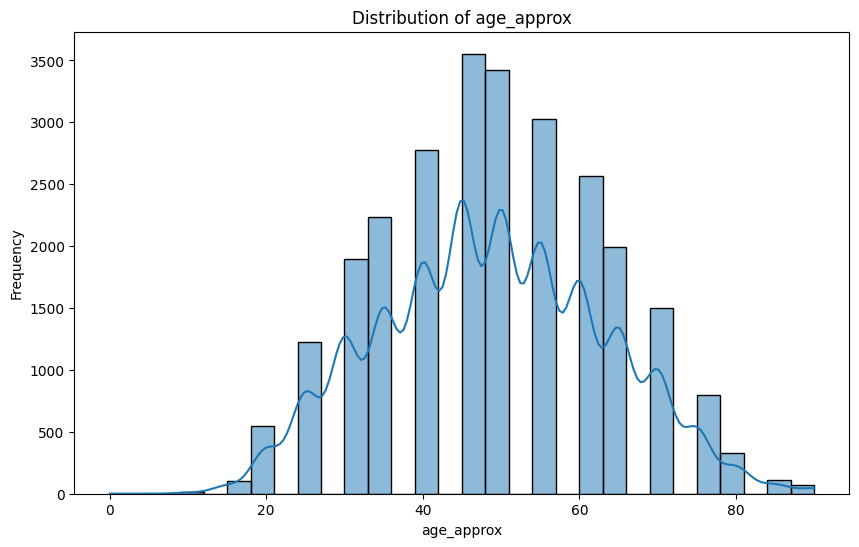

In [138]:
plot_data_distribution(train_data, 'age_approx') 

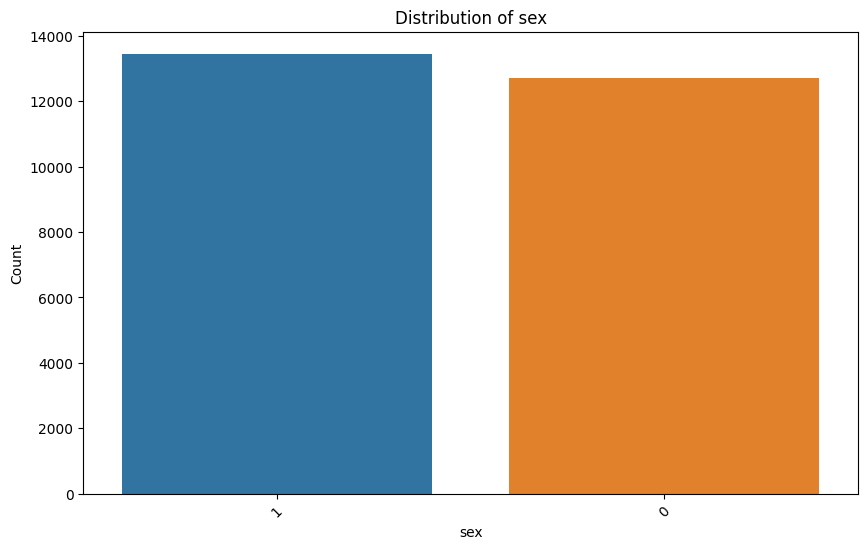

In [153]:
plot_data_distribution(train_data, 'sex') 

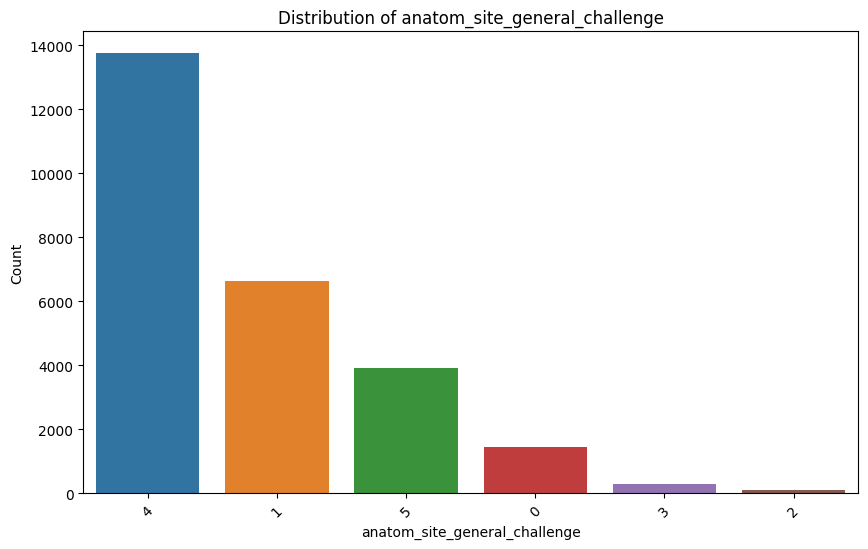

In [154]:
plot_data_distribution(train_data, 'anatom_site_general_challenge') 

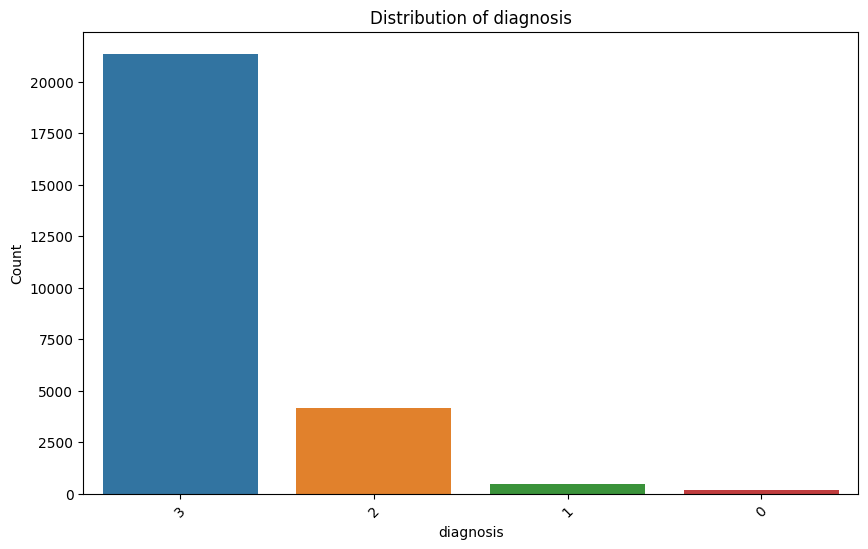

In [155]:
plot_data_distribution(train_data, 'diagnosis') 

In [171]:
def plot_distribution_by_diagnosis(df, column_name):
    plt.figure(figsize=(10, 6))
    
    if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
        # It's categorical, use countplot
        ax = sns.countplot(data=df, x=column_name, hue='diagnosis', order=df[column_name].value_counts().index)
        plt.title(f'Distribution of {column_name} by Diagnosis')
        plt.xlabel(column_name)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')
    else:
        # It's numerical, use histplot
        sns.histplot(data=df, x=column_name, hue='diagnosis', kde=True, bins=30, multiple='stack')
        plt.title(f'Distribution of {column_name} by Diagnosis')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
    
    plt.show()

/tmp/ipykernel_33/1116259131.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

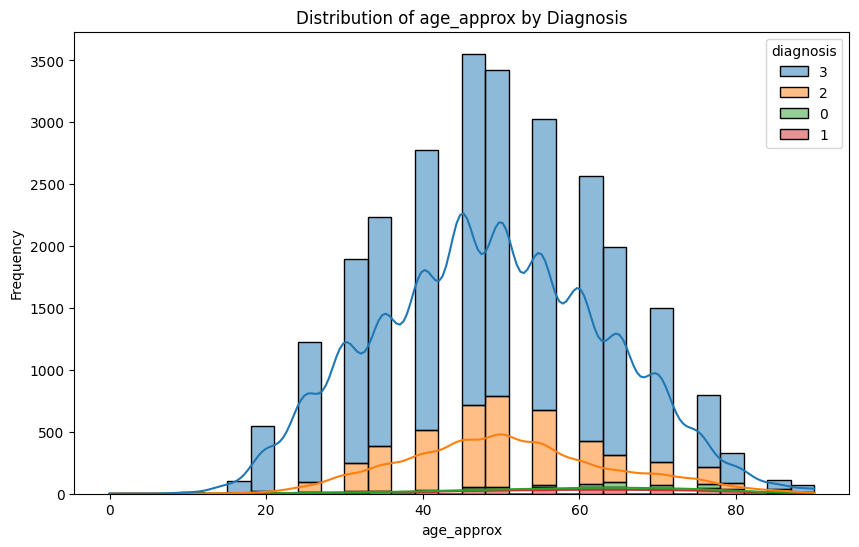

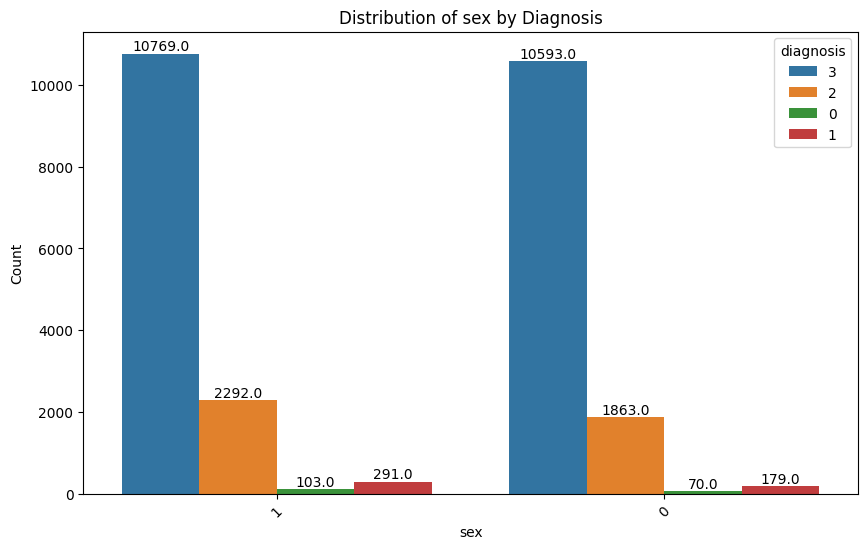

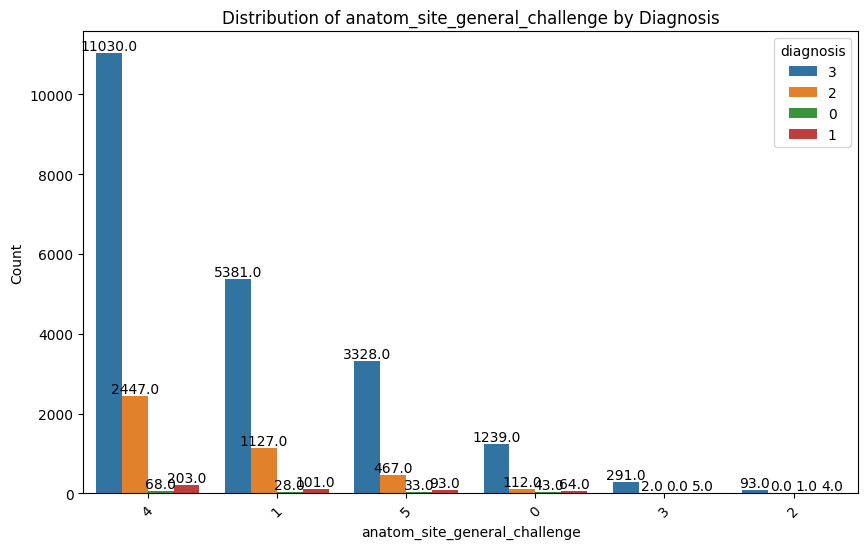

In [172]:
cols = ['age_approx', 'sex', 'anatom_site_general_challenge']
for col in cols:
    plot_distribution_by_diagnosis(train_data, col)

# 2. val_data

In [142]:
cols = ['sex', 'anatom_site_general_challenge','diagnosis']
for col in cols:
    convert_numerical_to_object(val_data, col)

Column 'sex' converted to object type.
Column 'anatom_site_general_challenge' converted to object type.
Column 'diagnosis' converted to object type.


/tmp/ipykernel_33/3562924322.py:2: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


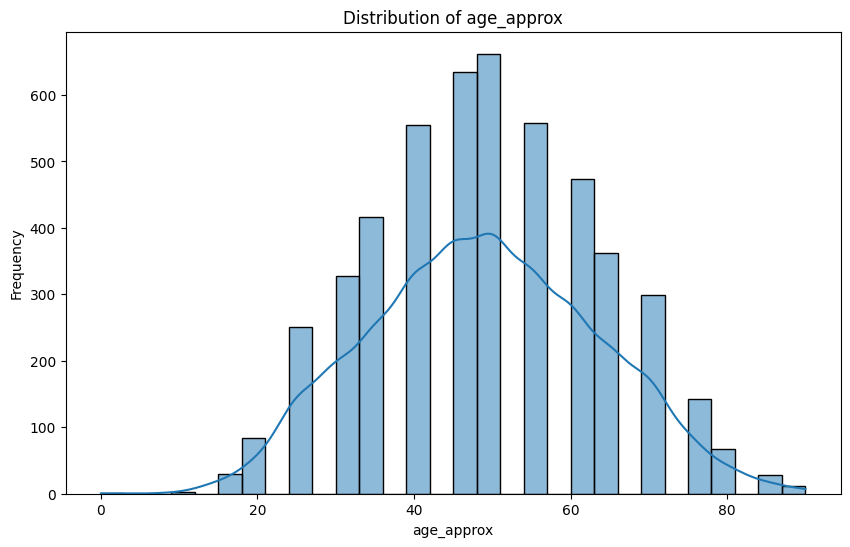

In [156]:
plot_data_distribution(val_data, 'age_approx') 

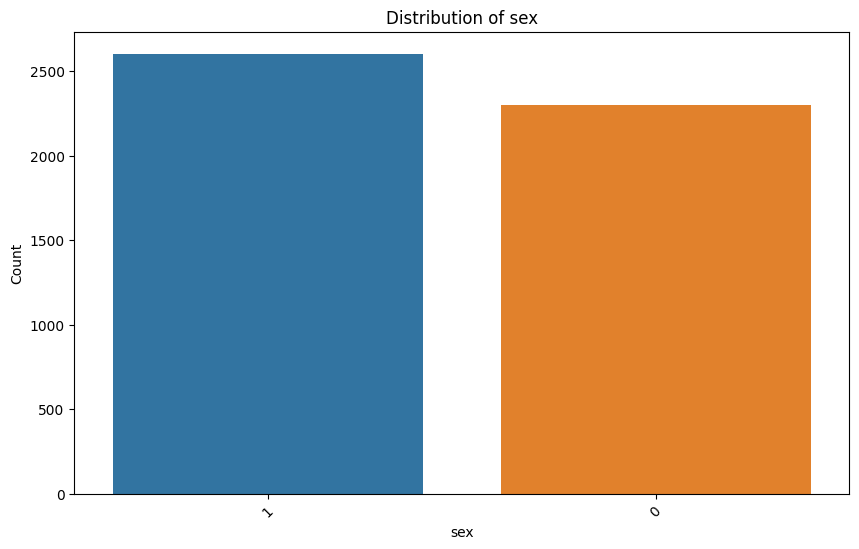

In [157]:
plot_data_distribution(val_data, 'sex') 

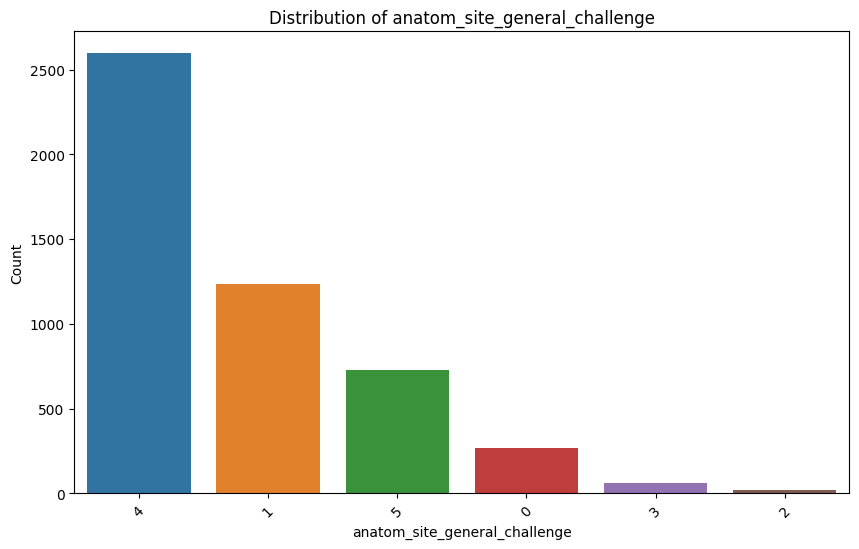

In [158]:
plot_data_distribution(val_data, 'anatom_site_general_challenge') 

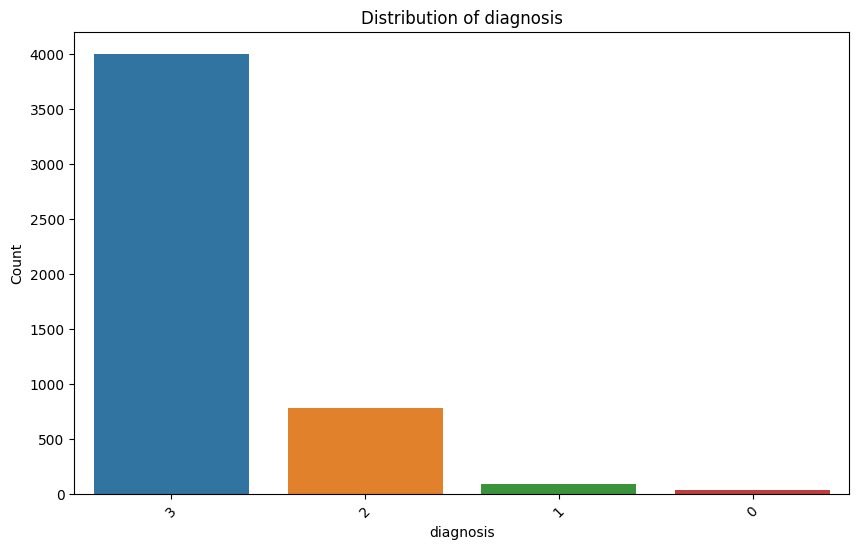

In [159]:
plot_data_distribution(val_data, 'diagnosis') 

/tmp/ipykernel_33/1116259131.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

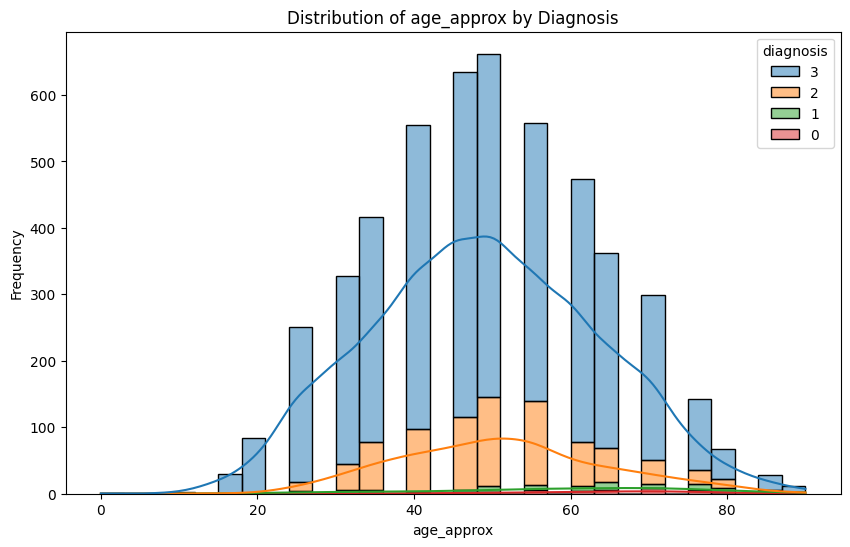

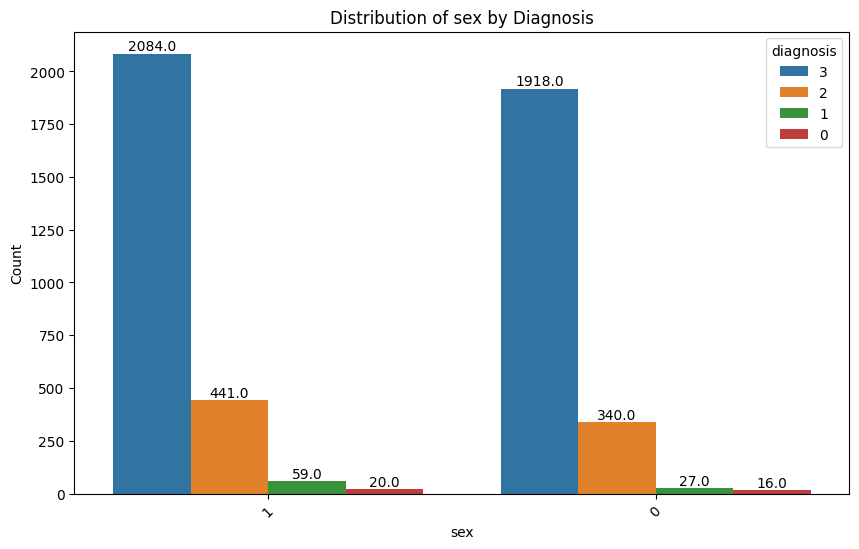

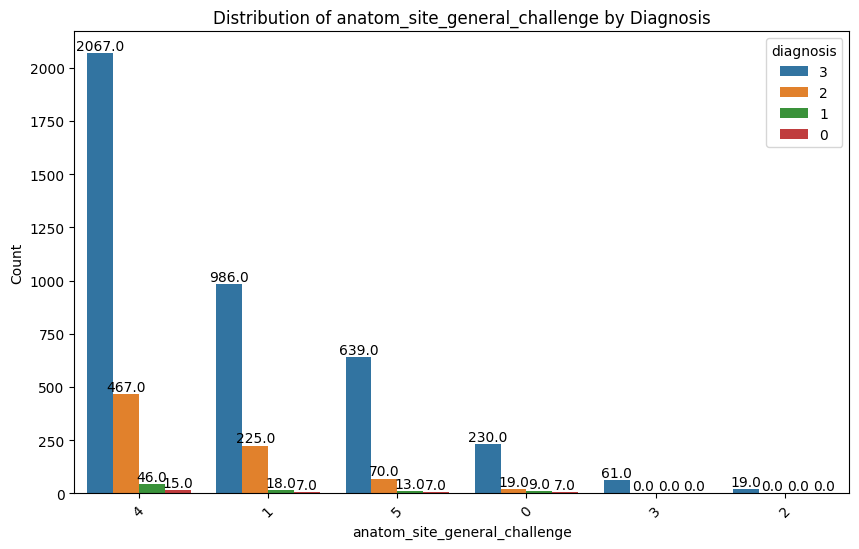

In [173]:
cols = ['age_approx', 'sex', 'anatom_site_general_challenge']
for col in cols:
    plot_distribution_by_diagnosis(val_data, col)

# 3. test_data

In [147]:
cols = ['sex', 'anatom_site_general_challenge','diagnosis']
for col in cols:
    convert_numerical_to_object(test_data, col)

Column 'sex' converted to object type.
Column 'anatom_site_general_challenge' converted to object type.
Column 'diagnosis' converted to object type.


/tmp/ipykernel_33/3582844581.py:2: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


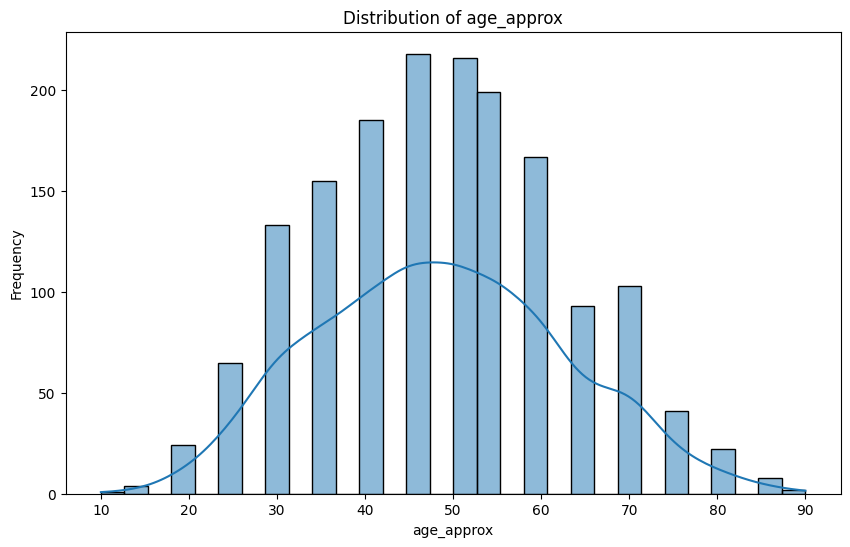

In [148]:
plot_data_distribution(test_data, 'age_approx') 

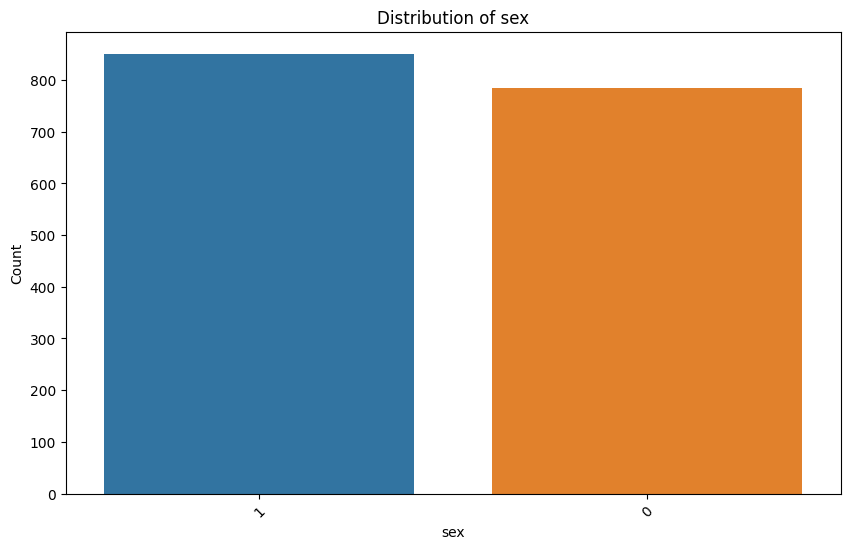

In [160]:
plot_data_distribution(test_data, 'sex') 

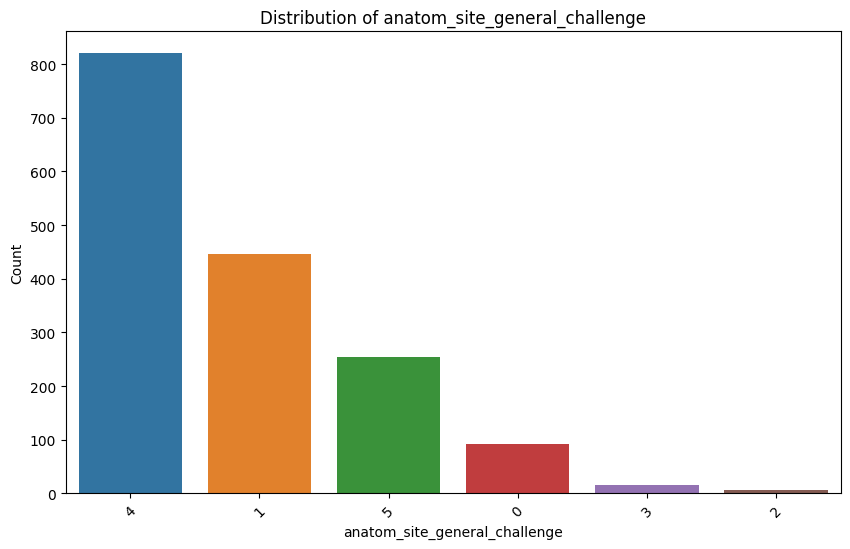

In [161]:
plot_data_distribution(test_data, 'anatom_site_general_challenge') 

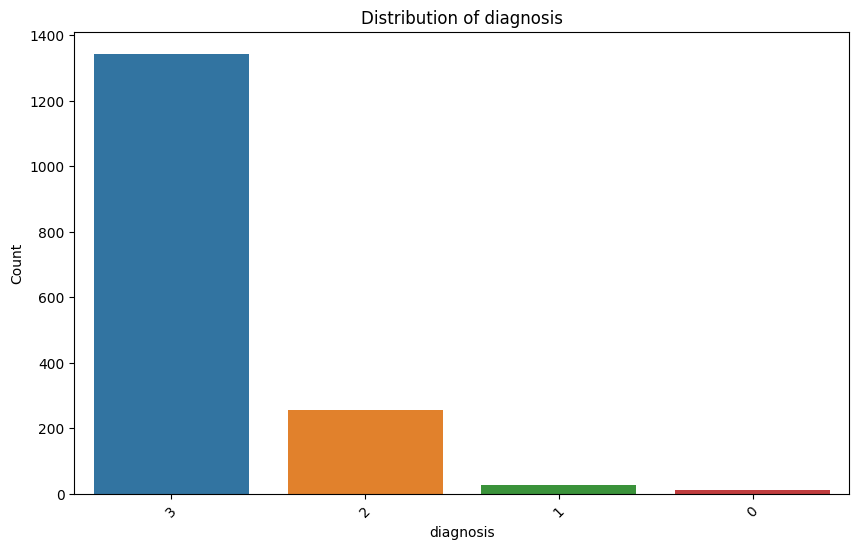

In [162]:
plot_data_distribution(test_data, 'diagnosis') 

/tmp/ipykernel_33/1116259131.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

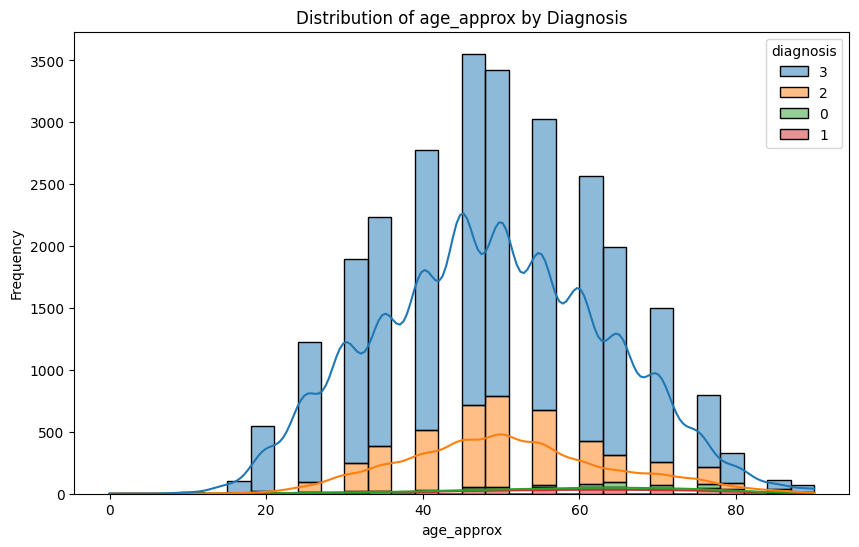

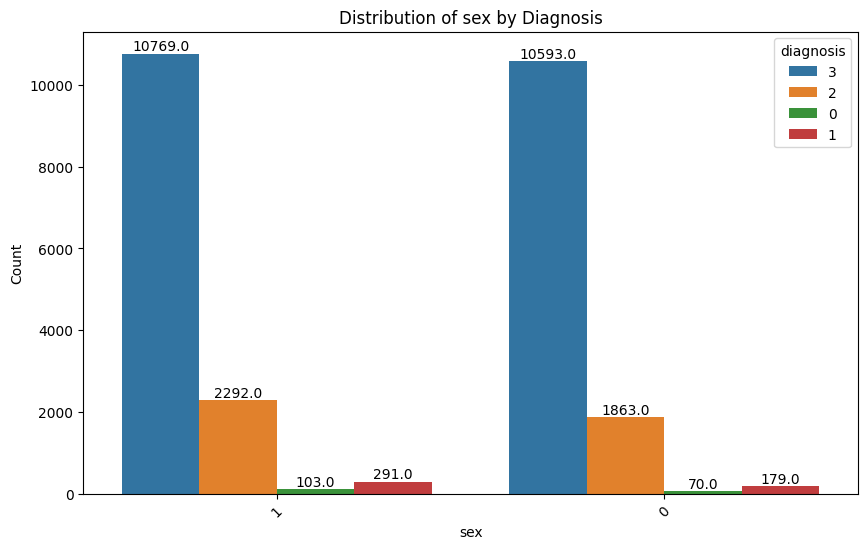

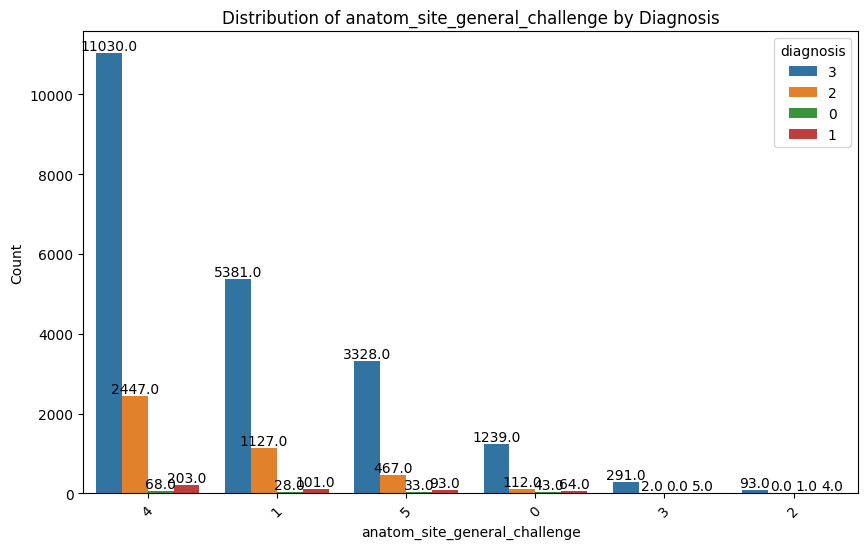

In [174]:
cols = ['age_approx', 'sex', 'anatom_site_general_challenge']
for col in cols:
    plot_distribution_by_diagnosis(train_data, col)